In [1]:
library("devtools")
library("tidyverse")
library("EnhancedVolcano")

Loading required package: usethis

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.2          v readr     2.1.4     
v forcats   1.0.0.9000     v stringr   1.5.0     
v ggplot2   3.4.3          v tibble    3.2.1     
v lubridate 1.9.2          v tidyr     1.3.0     
v purrr     1.0.1          
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: ggrepel



In [2]:
all_acrs <- read_delim("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/03.peak_assignment/zm_dir/zm_acr_classification.no_exons.all_ACRs.classified.sorted.bed", delim = "\t", col_names = c("chr", "start", "stop", "acr_name", "score")) %>% 
    separate(acr_name, into = c("ACR_number", "ACR_Class"), sep = ";")
    
number_cell_type_acrs <- all_acrs %>% 
    dplyr::group_by(ACR_Class) %>% 
    summarise(acr_per_ct = n())

Rows: 55504 Columns: 5
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (3): chr, acr_name, score
dbl (2): start, stop

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
control_ACRs_cell_type <- read_delim("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/06.motif_enrichment/zm_dir/control_bed/zm.bundle_sheath.broad_acr_null_list.bed", delim = "\t", col_names = c("chr", "start", "stop", "acr_name", "score")) %>% 
    separate(acr_name, into = c("ACR_number", "ACR_Class"), sep = ";")
    

Rows: 531 Columns: 5
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (2): chr, acr_name
dbl (2): start, stop
lgl (1): score

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
fimo_output_tsv <- read_tsv("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/06.motif_enrichment/zm_dir/all_acrs/zm_fimo_output/fimo.tsv")
fimo_output_tsv <- fimo_output_tsv #%>% 
 #   separate(sequence_name, into = c("ACR_number", "acr_type_location"), sep = ";") %>% 
 #   separate(acr_type_location, into = c("ACR_Class", "location"), sep = "::")



Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 8270218 Columns: 10
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (5): motif_id, motif_alt_id, sequence_name, strand, matched_sequence
dbl (5): start, stop, score, p-value, q-value

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
fimo_output <- fimo_output_tsv %>% 
    separate(sequence_name, into = c("ACR_number", "acr_type_location"), sep = ";") %>% 
    separate(acr_type_location, into = c("ACR_Class", "location"), sep = "::")



In [6]:
cell_type_sepcific_acrs_contigency <- fimo_output %>% 
    dplyr::filter(ACR_Class != "broadly_accessible") %>% 
    group_by(motif_id, motif_alt_id, ACR_Class) %>% 
    summarise(counts = n())

`summarise()` has grouped output by 'motif_id', 'motif_alt_id'. You can
override using the `.groups` argument.


In [7]:
bundle_sheath_control_acrs <- fimo_output %>% 
    dplyr::filter(ACR_number %in% control_ACRs_cell_type$ACR_number) %>% 
    group_by(motif_id, motif_alt_id, ACR_Class) %>% 
    summarise(control_counts = n()) %>% 
    mutate(control_class = "bundle_sheath") %>% 
    select(-ACR_Class) %>% 
    select(motif_id, control_class, control_counts)

`summarise()` has grouped output by 'motif_id', 'motif_alt_id'. You can
override using the `.groups` argument.
Adding missing grouping variables: `motif_alt_id`


In [8]:
cell_type_sepcific_acrs_contigency_joined <- left_join(cell_type_sepcific_acrs_contigency, number_cell_type_acrs, by = c("ACR_Class"))

In [9]:
cell_type_sepcific_acrs_contigency_w_log2 <- cell_type_sepcific_acrs_contigency_joined %>% 
    dplyr::mutate(fraction_cts_acrs_w_motif = counts/acr_per_ct) %>% 
    filter(!str_detect(ACR_Class, ",")) %>% 
    left_join(., bundle_sheath_control_acrs, by = c("motif_id","ACR_Class" = "control_class")) %>% 
    dplyr::filter(ACR_Class == "bundle_sheath") %>% 
    dplyr::mutate(fraction_control_w_motif = control_counts/acr_per_ct) %>% 
    rowwise() %>% 
    mutate(log2FoldChange = log2(fraction_cts_acrs_w_motif/fraction_control_w_motif),
            test_stat = chisq.test(c(counts, control_counts))$statistic,
            p_val = chisq.test(c(counts, control_counts))$p.value) %>% 
    ungroup() %>% 
    mutate(adjusted_pval = p.adjust(p_val, method="fdr")) %>% 
  group_by(motif_alt_id.x ) %>%
  mutate(row_num = case_when(n() > 1 ~ as.character(row_number()), TRUE ~ "")) %>%
  ungroup() %>%
  mutate(motif_alt_id = paste0(motif_alt_id.x ,".", row_num)) %>%
  select(-row_num)

    

In [10]:
head(cell_type_sepcific_acrs_contigency_w_log2)

motif_id,motif_alt_id.x,ACR_Class,counts,acr_per_ct,fraction_cts_acrs_w_motif,motif_alt_id.y,control_counts,fraction_control_w_motif,log2FoldChange,test_stat,p_val,adjusted_pval,motif_alt_id
<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
MA0001.2,AGL3,bundle_sheath,29,531,0.05461394,AGL3,32,0.06026365,-0.1420190,0.147541,0.700896446,0.79582493,AGL3.
MA0005.2,AG,bundle_sheath,13,531,0.02448211,AG,32,0.06026365,-1.2995603,8.022222,0.004620684,0.01801237,AG.
MA0008.3,HAT5,bundle_sheath,40,531,0.07532957,HAT5,53,0.09981168,-0.4059924,1.817204,0.177646417,0.31822405,HAT5.
MA0034.1,Gam1,bundle_sheath,61,531,0.11487759,Gam1,77,0.14500942,-0.3360492,1.855072,0.173194587,0.31319355,Gam1.
MA0054.1,myb.Ph3,bundle_sheath,18,531,0.03389831,myb.Ph3,22,0.04143126,-0.2895066,0.400000,0.527089257,0.66380756,myb.Ph3.
MA0082.1,squamosa,bundle_sheath,55,531,0.10357815,squamosa,69,0.12994350,-0.3271647,1.580645,0.208667788,0.35130699,squamosa.


In [11]:
calculate_chi_square <- cell_type_sepcific_acrs_contigency_w_log2

In [12]:
calculate_chi_square_subset <- calculate_chi_square %>% 
    select(motif_alt_id, log2FoldChange, adjusted_pval)


calculate_chi_square_subset.df <- as.data.frame(calculate_chi_square_subset)
row.names(calculate_chi_square_subset.df) <- calculate_chi_square_subset.df$motif_alt_id
res <- calculate_chi_square_subset.df[,2:3]

In [137]:
arrange(calculate_chi_square_subset, by = adjusted_pval)

motif_alt_id,log2FoldChange,adjusted_pval
<chr>,<dbl>,<dbl>
Zm00001d005892.,-1.0780738,1.423206e-182
Zm00001d049364.,-1.2782289,1.149442e-179
LEP.,-1.0762035,3.102777e-155
Zm00001d020267.,-1.3221940,5.189490e-151
ERF115.,-1.1264970,4.324649e-148
LOB.,-1.3716607,8.290873e-146
Zm00001d024324.,-1.2595984,4.035077e-139
PATZ1.,-1.1475276,5.105108e-135
ERF9.,-0.9938869,7.935076e-135


Warning message:
"ggrepel: 57 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


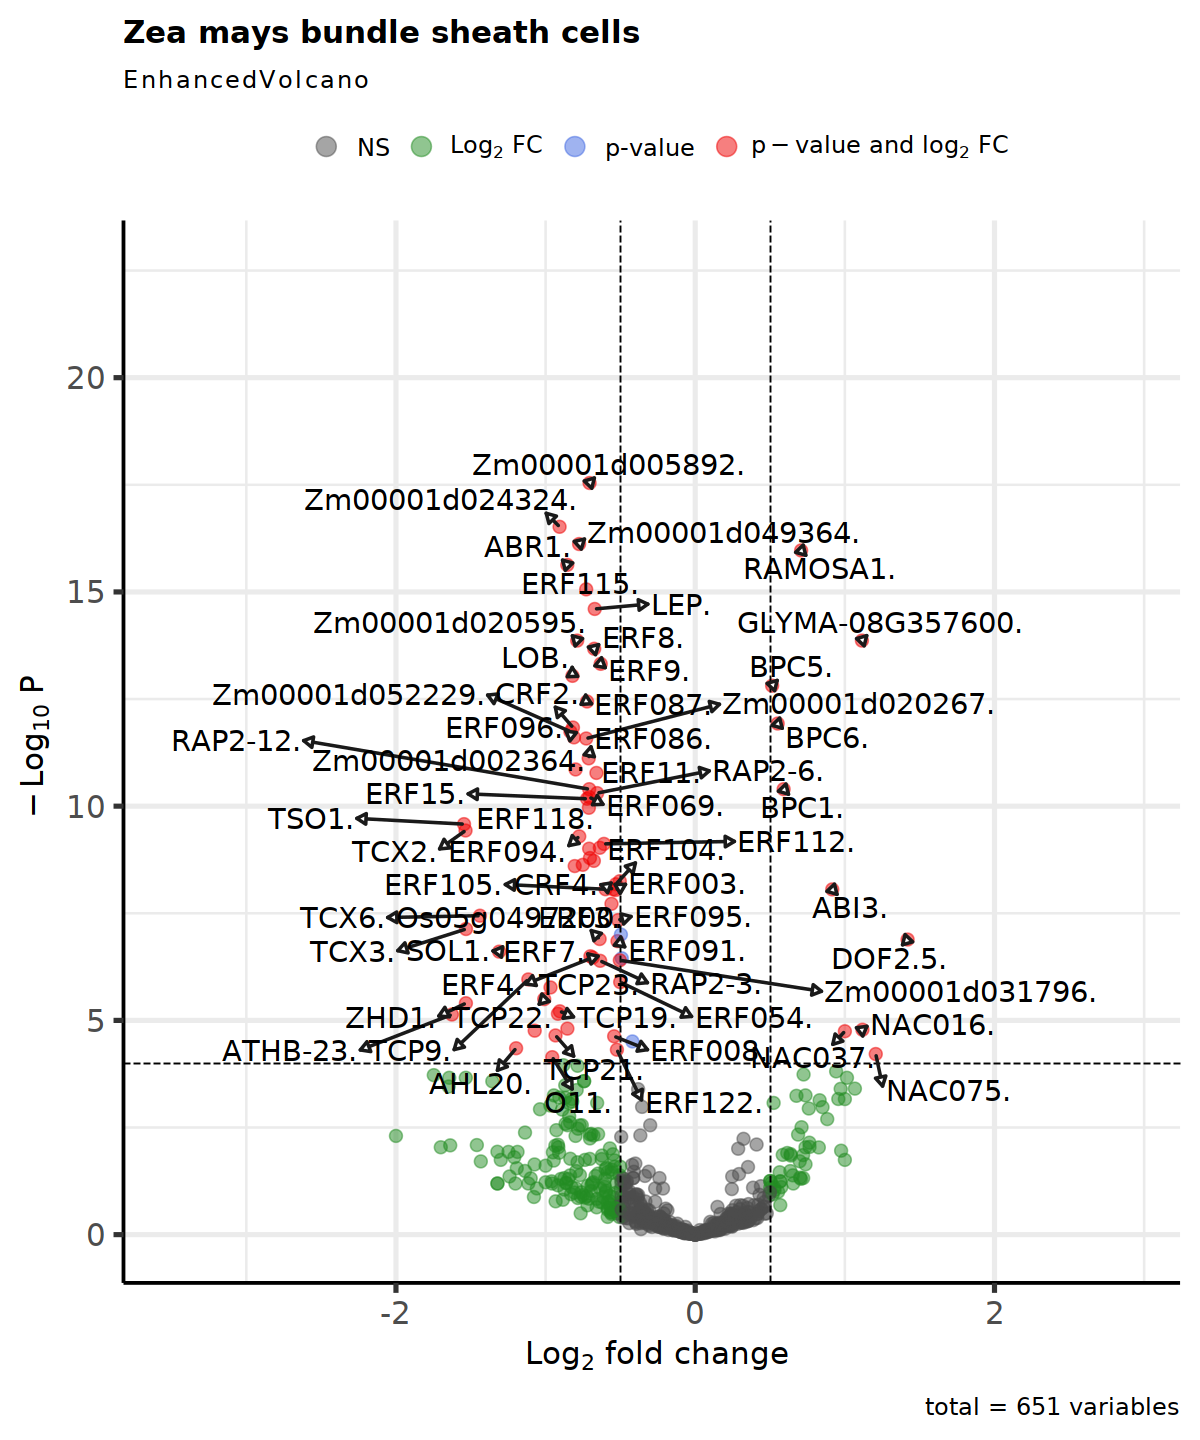

In [29]:
options(repr.plot.width=10, repr.plot.height=12)

EnhancedVolcano(res,
    lab = rownames(res),
    x = 'log2FoldChange',
    y = 'adjusted_pval',
    title = 'Zea mays bundle sheath cells',
    pCutoff = 10e-5,
    FCcutoff = 0.5,
    pointSize = 3.0,
    labSize = 6.0,
    drawConnectors = TRUE,
    widthConnectors = 0.75)

# Mesophyll Try

In [14]:
mesophyll_control_ACRs_cell_type <- read_delim("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/06.motif_enrichment/zm_dir/control_bed/zm.mesophyll.broad_acr_null_list.bed", delim = "\t", col_names = c("chr", "start", "stop", "acr_name", "score")) %>% 
    separate(acr_name, into = c("ACR_number", "ACR_Class"), sep = ";")
    

mesophyll_control_acrs <- fimo_output %>% 
    dplyr::filter(ACR_number %in% mesophyll_control_ACRs_cell_type$ACR_number) %>% 
    group_by(motif_id, motif_alt_id, ACR_Class) %>% 
    summarise(control_counts = n()) %>% 
    mutate(control_class = "mesophyll") %>% 
    select(-ACR_Class) %>% 
    select(motif_id, control_class, control_counts)

Rows: 1197 Columns: 5
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (2): chr, acr_name
dbl (2): start, stop
lgl (1): score

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'motif_id', 'motif_alt_id'. You can
override using the `.groups` argument.
Adding missing grouping variables: `motif_alt_id`


In [15]:
cell_type_sepcific_acrs_contigency_meso <- left_join(cell_type_sepcific_acrs_contigency, number_cell_type_acrs, by = c("ACR_Class"))

In [16]:
cell_type_sepcific_acrs_contigency_w_log2_meso <- cell_type_sepcific_acrs_contigency_meso %>% 
    dplyr::mutate(fraction_cts_acrs_w_motif = counts/acr_per_ct) %>% 
    filter(!str_detect(ACR_Class, ",")) %>% 
    left_join(., mesophyll_control_acrs, by = c("motif_id","ACR_Class" = "control_class")) %>% 
    dplyr::filter(ACR_Class == "mesophyll") %>% 
    dplyr::mutate(fraction_control_w_motif = control_counts/acr_per_ct) %>% 
    rowwise() %>% 
    mutate(log2FoldChange = log2(fraction_cts_acrs_w_motif/fraction_control_w_motif),
            test_stat = chisq.test(c(counts, control_counts))$statistic,
            p_val = chisq.test(c(counts, control_counts))$p.value) %>% 
    ungroup() %>% 
    mutate(adjusted_pval = p.adjust(p_val, method="fdr")) %>% 
  group_by(motif_alt_id.x ) %>%
  mutate(row_num = case_when(n() > 1 ~ as.character(row_number()), TRUE ~ "")) %>%
  ungroup() %>%
  mutate(motif_alt_id = paste0(motif_alt_id.x ,".", row_num)) %>%
  select(-row_num)

    

In [17]:
calculate_chi_square_subset_meso <- cell_type_sepcific_acrs_contigency_w_log2_meso %>% 
    select(motif_alt_id, log2FoldChange, adjusted_pval)


calculate_chi_square_subset_meso.df <- as.data.frame(calculate_chi_square_subset_meso)
row.names(calculate_chi_square_subset_meso.df) <- calculate_chi_square_subset_meso.df$motif_alt_id
res_meso <- calculate_chi_square_subset_meso.df[,2:3]

In [18]:
res_meso

,log2FoldChange,adjusted_pval
,<dbl>,<dbl>
AGL3.,-0.57730893,3.244889e-02
AG.,-0.36923381,2.728893e-01
HAT5.,0.00000000,1.000000e+00
Gam1.,-0.09310940,6.579958e-01
myb.Ph3.,-0.14017766,7.069537e-01
squamosa.,-0.50404251,1.352102e-02
bZIP910.,0.26651497,3.609315e-01
bZIP911.,0.05377126,7.565378e-01
ATHB-5.,-0.13750352,6.082888e-01


In [19]:
arrange(calculate_chi_square_subset, by = adjusted_pval)

motif_alt_id,log2FoldChange,adjusted_pval
<chr>,<dbl>,<dbl>
Zm00001d005892.,-0.7061100,2.871400e-18
Zm00001d024324.,-0.9065813,3.021501e-17
Zm00001d049364.,-0.7762024,7.627041e-17
RAMOSA1.,0.7077056,1.077464e-16
ABR1.,-0.8552649,2.338029e-16
ERF115.,-0.7286980,8.709713e-16
LEP.,-0.6715679,2.498163e-15
GLYMA-08G357600.,1.1140718,1.368608e-14
Zm00001d020595.,-0.7889310,1.368608e-14


In [20]:
calculate_chi_square_subset %>% 
    filter(str_detect(motif_alt_id, "DOF"))

motif_alt_id,log2FoldChange,adjusted_pval
<chr>,<dbl>,<dbl>
DOF2.5.,1.41922530,1.297074e-07
DOF1.8.,0.76250069,7.150085e-03
DOF2.4.,0.72084593,1.393210e-02
DOF5.6.,1.00000000,1.801897e-02
DOF5.7.,1.01407519,2.184854e-04
DOF5.3.,0.61508249,1.243354e-02
DOF5.8.,0.14848783,2.252510e-01
DOF4.5.,0.57511471,7.788735e-02
DOF3.2.,0.52390097,8.442337e-04


Warning message:
"ggrepel: 43 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


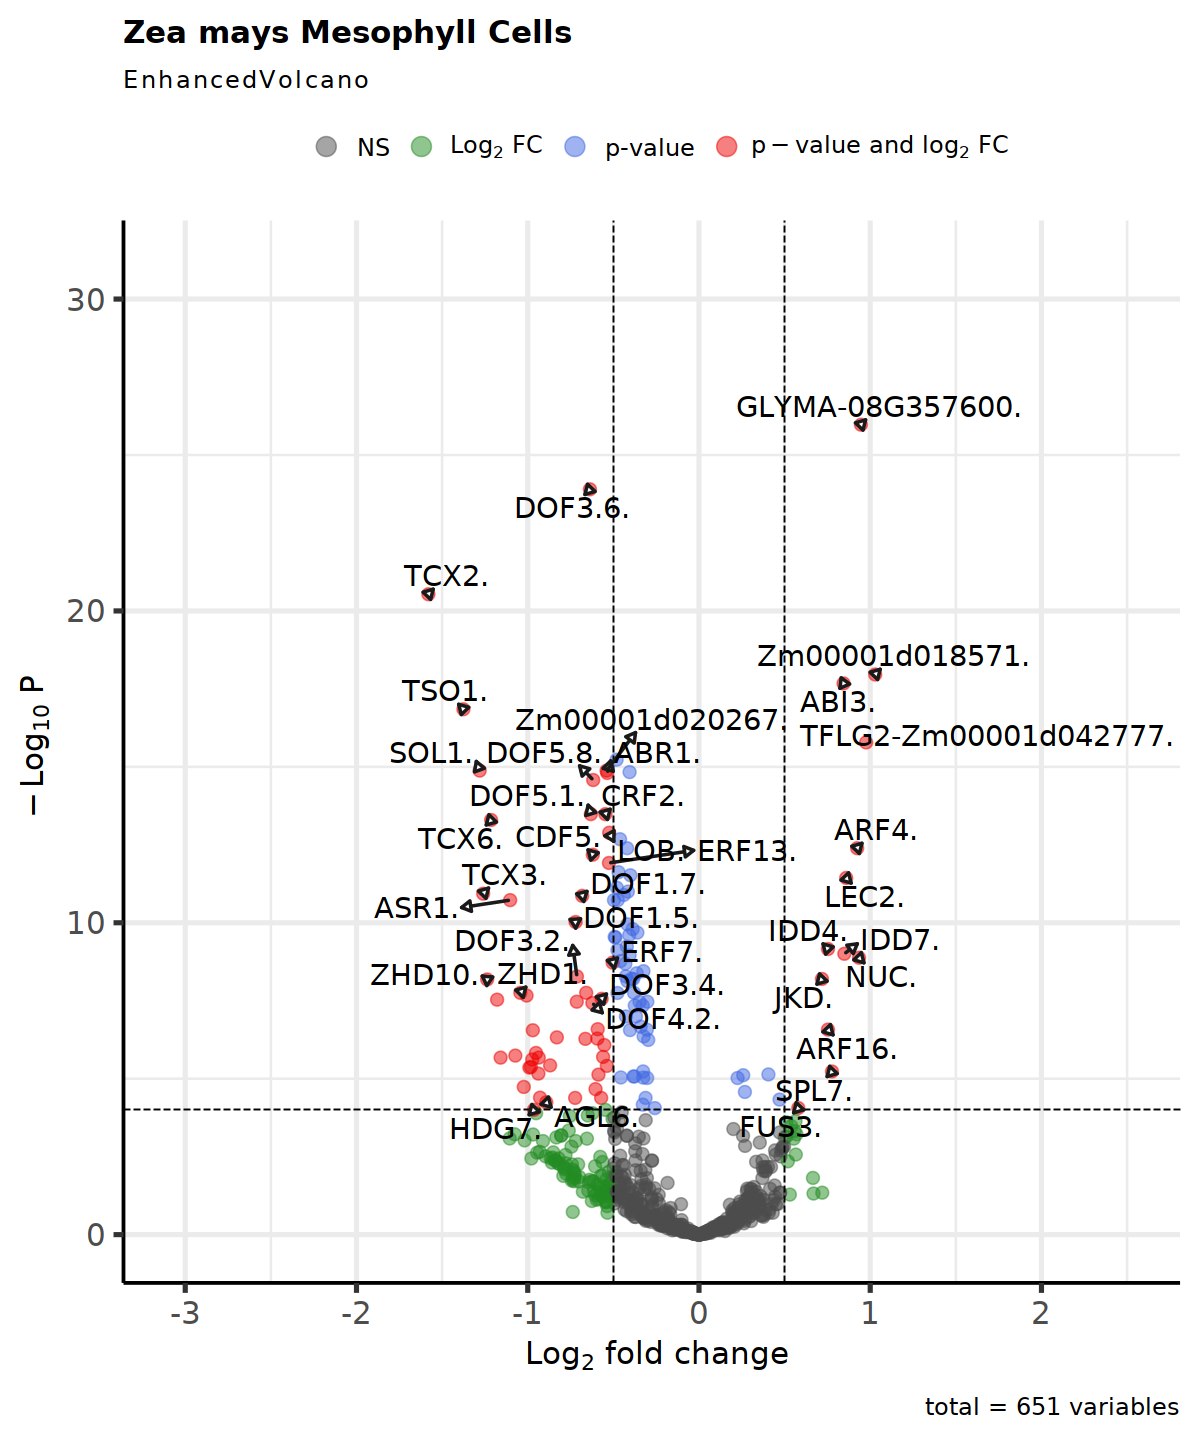

In [28]:
options(repr.plot.width=10, repr.plot.height=12)

EnhancedVolcano(res_meso,
    lab = rownames(res_meso),
    x = 'log2FoldChange',
    y = 'adjusted_pval',
    title = 'Zea mays Mesophyll Cells',
    pCutoff = 10e-5,
    FCcutoff = 0.5,
    pointSize = 3.0,
    labSize = 6.0,
    drawConnectors = TRUE,
    widthConnectors = 0.75)